# Loading and saving the dataset

In [1]:
from datasets import load_dataset

# Load dataset from huggingface
dataset = load_dataset("Micol/musical-instruments-sound-dataset")

In [2]:
# Optional -> save to disk to prevent re-download
# dataset.save_to_disk("data/")

---------
# Dataset preprocessing

In [3]:
import torch
from torchaudio.transforms import MFCC, Resample
from torch.utils.data import DataLoader, Dataset as TorchDataset

In [4]:
# Parameters for data and model
N_MFCC = 15
TARGET_SR = 44100
DURATION = 2

In [5]:
# Define a custom PyTorch Dataset for pre-processing
class AudioDataset(TorchDataset):
    def __init__(self, dataset, target_sr=TARGET_SR, fixed_duration=DURATION, n_mfcc=N_MFCC):
        """
        Custom PyTorch Dataset for audio classification with MFCCs.
        
        Args:
            dataset: Hugging Face dataset containing 'audio' and 'label' columns.
            target_sr: Target sampling rate to resample all audio.
            fixed_duration: Fixed duration for all audio clips (in seconds).
            n_mfcc: Number of MFCC coefficients to extract.
        """
        self.dataset = dataset
        self.target_sr = target_sr
        self.num_samples = target_sr * fixed_duration
        self.n_mfcc = n_mfcc

        # MFCC transform
        self.mfcc_transform = MFCC(
            sample_rate=target_sr,
            n_mfcc=n_mfcc,
            melkwargs={
                "n_fft": 1024,
                "hop_length": 512,
                "n_mels": 64
            }
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load audio and label
        audio_array = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
        
        # Convert to PyTorch tensor
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        # Resample if needed
        if sr != self.target_sr:
            resample_transform = Resample(orig_freq=sr, new_freq=self.target_sr)
            audio_tensor = resample_transform(audio_tensor)

        # Find the loudest part of the audio
        max_idx = torch.argmax(audio_tensor)  # Find index of the loudest part
        start_idx = max(0, max_idx - self.target_sr)  # One second to the left
        end_idx = min(audio_tensor.size(0), max_idx + self.target_sr)  # One second to the right

        audio_tensor = audio_tensor[start_idx:end_idx]

        # Pad or truncate to fixed length
        if audio_tensor.shape[0] > self.num_samples:
            audio_tensor = audio_tensor[:self.num_samples]  # Truncate
        else:
            padding = self.num_samples - audio_tensor.shape[0]
            audio_tensor = torch.nn.functional.pad(audio_tensor, (0, padding))  # Pad with zeros

        # Convert to MFCC
        mfcc = self.mfcc_transform(audio_tensor)

        return mfcc, label

In [6]:
# Split dataset into train and test sets
train_dataset = AudioDataset(dataset['train'])
validation_dataset = AudioDataset(dataset['validation'])
test_dataset = AudioDataset(dataset['test'])

In [7]:
# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

This time the datasets will return the mfcc not the spectrogram

----
# Model implementation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves the dimensions

        # Fully connected layers
        self.fc1 = nn.Linear(64 * (N_MFCC // 8) * (DURATION * TARGET_SR // 8 // 512), 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [10]:
# Number of classes based on dataset
num_classes = len(dataset['train'].features['label'].names)

# Instantiate the model
model = AudioClassifier(num_classes=num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function and scheduler this time
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [11]:
from tqdm import tqdm

# train loop
def train(model, train_loader, validation_loader, criterion, optimizer, device, epochs, scheduler = None):
    best_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for mel_spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)  # Add channel dimension
            labels = labels.to(device)

            # Forward pass
            outputs = model(mel_spectrograms)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrograms, labels in validation_loader:
                mel_spectrograms = mel_spectrograms.unsqueeze(1).to(device)
                labels = labels.to(device)

                outputs = model(mel_spectrograms)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct / total

        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step(avg_val_loss)

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Train Accuracy = {train_accuracy:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val Accuracy = {val_accuracy:.4f}")

    return best_model_state, best_accuracy

In [12]:
#train(model, train_loader, validation_loader, criterion, optimizer, device, epochs=50)
best_model_state, best_accuracy = train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=50,
    scheduler=scheduler
)

Epoch 1/50: 100%|██████████| 66/66 [01:05<00:00,  1.00it/s]


Epoch 1: Train Loss = 1.2308, Train Accuracy = 0.5250, Val Loss = 0.7188, Val Accuracy = 0.6046


Epoch 2/50: 100%|██████████| 66/66 [01:03<00:00,  1.03it/s]


Epoch 2: Train Loss = 0.6552, Train Accuracy = 0.6282, Val Loss = 0.6281, Val Accuracy = 0.5989


Epoch 3/50: 100%|██████████| 66/66 [01:06<00:00,  1.00s/it]


Epoch 3: Train Loss = 0.5667, Train Accuracy = 0.6581, Val Loss = 0.5994, Val Accuracy = 0.6445


Epoch 4/50: 100%|██████████| 66/66 [01:06<00:00,  1.00s/it]


Epoch 4: Train Loss = 0.5484, Train Accuracy = 0.6857, Val Loss = 0.6143, Val Accuracy = 0.6749


Epoch 5/50: 100%|██████████| 66/66 [01:06<00:00,  1.00s/it]


Epoch 5: Train Loss = 0.5098, Train Accuracy = 0.6933, Val Loss = 0.5391, Val Accuracy = 0.6635


Epoch 6/50: 100%|██████████| 66/66 [01:06<00:00,  1.01s/it]


Epoch 6: Train Loss = 0.4778, Train Accuracy = 0.6914, Val Loss = 0.5164, Val Accuracy = 0.6407


Epoch 7/50: 100%|██████████| 66/66 [01:05<00:00,  1.00it/s]


Epoch 7: Train Loss = 0.4762, Train Accuracy = 0.7066, Val Loss = 0.5412, Val Accuracy = 0.6863


Epoch 8/50: 100%|██████████| 66/66 [01:04<00:00,  1.02it/s]


Epoch 8: Train Loss = 0.4454, Train Accuracy = 0.7204, Val Loss = 0.6100, Val Accuracy = 0.6597


Epoch 9/50: 100%|██████████| 66/66 [01:05<00:00,  1.01it/s]


Epoch 9: Train Loss = 0.4732, Train Accuracy = 0.6995, Val Loss = 0.5822, Val Accuracy = 0.6635


Epoch 10/50: 100%|██████████| 66/66 [01:06<00:00,  1.01s/it]


Epoch 10: Train Loss = 0.4535, Train Accuracy = 0.7133, Val Loss = 0.5272, Val Accuracy = 0.6521


Epoch 11/50: 100%|██████████| 66/66 [01:05<00:00,  1.00it/s]


Epoch 11: Train Loss = 0.4141, Train Accuracy = 0.7380, Val Loss = 0.4933, Val Accuracy = 0.6445


Epoch 12/50: 100%|██████████| 66/66 [01:05<00:00,  1.01it/s]


Epoch 12: Train Loss = 0.4042, Train Accuracy = 0.7413, Val Loss = 0.5003, Val Accuracy = 0.6274


Epoch 13/50: 100%|██████████| 66/66 [01:05<00:00,  1.00it/s]


Epoch 13: Train Loss = 0.4009, Train Accuracy = 0.7380, Val Loss = 0.4937, Val Accuracy = 0.6331


Epoch 14/50: 100%|██████████| 66/66 [01:07<00:00,  1.02s/it]


Epoch 14: Train Loss = 0.3990, Train Accuracy = 0.7356, Val Loss = 0.4974, Val Accuracy = 0.6046


Epoch 15/50: 100%|██████████| 66/66 [01:08<00:00,  1.03s/it]


Epoch 15: Train Loss = 0.3920, Train Accuracy = 0.7328, Val Loss = 0.5024, Val Accuracy = 0.6274


Epoch 16/50: 100%|██████████| 66/66 [01:07<00:00,  1.03s/it]


Epoch 16: Train Loss = 0.3862, Train Accuracy = 0.7499, Val Loss = 0.5023, Val Accuracy = 0.6198


Epoch 17/50: 100%|██████████| 66/66 [01:07<00:00,  1.03s/it]


Epoch 17: Train Loss = 0.3879, Train Accuracy = 0.7427, Val Loss = 0.5020, Val Accuracy = 0.6141


Epoch 18/50: 100%|██████████| 66/66 [01:06<00:00,  1.01s/it]


Epoch 18: Train Loss = 0.3854, Train Accuracy = 0.7389, Val Loss = 0.5018, Val Accuracy = 0.6160


Epoch 19/50: 100%|██████████| 66/66 [00:50<00:00,  1.29it/s]


Epoch 19: Train Loss = 0.3849, Train Accuracy = 0.7494, Val Loss = 0.5019, Val Accuracy = 0.6122


Epoch 20/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 20: Train Loss = 0.3828, Train Accuracy = 0.7589, Val Loss = 0.5020, Val Accuracy = 0.6122


Epoch 21/50: 100%|██████████| 66/66 [00:52<00:00,  1.25it/s]


Epoch 21: Train Loss = 0.3877, Train Accuracy = 0.7275, Val Loss = 0.5021, Val Accuracy = 0.6103


Epoch 22/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 22: Train Loss = 0.3847, Train Accuracy = 0.7480, Val Loss = 0.5022, Val Accuracy = 0.6122


Epoch 23/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 23: Train Loss = 0.3872, Train Accuracy = 0.7499, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 24/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 24: Train Loss = 0.3856, Train Accuracy = 0.7442, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 25/50: 100%|██████████| 66/66 [00:49<00:00,  1.32it/s]


Epoch 25: Train Loss = 0.3889, Train Accuracy = 0.7404, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 26/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 26: Train Loss = 0.3856, Train Accuracy = 0.7442, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 27/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 27: Train Loss = 0.3858, Train Accuracy = 0.7451, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 28/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 28: Train Loss = 0.3826, Train Accuracy = 0.7622, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 29/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 29: Train Loss = 0.3855, Train Accuracy = 0.7537, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 30/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 30: Train Loss = 0.3878, Train Accuracy = 0.7399, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 31/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 31: Train Loss = 0.3854, Train Accuracy = 0.7456, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 32/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 32: Train Loss = 0.3847, Train Accuracy = 0.7561, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 33/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 33: Train Loss = 0.3849, Train Accuracy = 0.7532, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 34/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 34: Train Loss = 0.3856, Train Accuracy = 0.7589, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 35/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 35: Train Loss = 0.3877, Train Accuracy = 0.7466, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 36/50: 100%|██████████| 66/66 [00:51<00:00,  1.29it/s]


Epoch 36: Train Loss = 0.3859, Train Accuracy = 0.7565, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 37/50: 100%|██████████| 66/66 [00:50<00:00,  1.30it/s]


Epoch 37: Train Loss = 0.3847, Train Accuracy = 0.7489, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 38/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 38: Train Loss = 0.3853, Train Accuracy = 0.7542, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 39/50: 100%|██████████| 66/66 [00:49<00:00,  1.32it/s]


Epoch 39: Train Loss = 0.3855, Train Accuracy = 0.7456, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 40/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 40: Train Loss = 0.3859, Train Accuracy = 0.7489, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 41/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 41: Train Loss = 0.3844, Train Accuracy = 0.7461, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 42/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 42: Train Loss = 0.3850, Train Accuracy = 0.7513, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 43/50: 100%|██████████| 66/66 [00:49<00:00,  1.32it/s]


Epoch 43: Train Loss = 0.3852, Train Accuracy = 0.7489, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 44/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 44: Train Loss = 0.3866, Train Accuracy = 0.7570, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 45/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 45: Train Loss = 0.3852, Train Accuracy = 0.7470, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 46/50: 100%|██████████| 66/66 [00:49<00:00,  1.32it/s]


Epoch 46: Train Loss = 0.3856, Train Accuracy = 0.7480, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 47/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 47: Train Loss = 0.3886, Train Accuracy = 0.7461, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 48/50: 100%|██████████| 66/66 [00:50<00:00,  1.31it/s]


Epoch 48: Train Loss = 0.3841, Train Accuracy = 0.7480, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 49/50: 100%|██████████| 66/66 [00:50<00:00,  1.32it/s]


Epoch 49: Train Loss = 0.3841, Train Accuracy = 0.7508, Val Loss = 0.5023, Val Accuracy = 0.6122


Epoch 50/50: 100%|██████████| 66/66 [00:49<00:00,  1.33it/s]


Epoch 50: Train Loss = 0.3834, Train Accuracy = 0.7518, Val Loss = 0.5023, Val Accuracy = 0.6122


-----
# Evaluate

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 0.6125
Confusion Matrix:


<Figure size 1000x700 with 0 Axes>

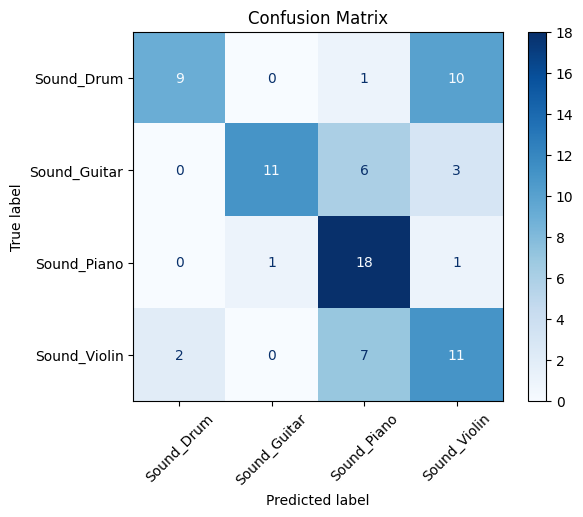

In [14]:
def evaluate(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spectrograms, labels in test_loader:
            mel_spectrograms, labels = mel_spectrograms.unsqueeze(1).to(device), labels.to(device)

            outputs = model(mel_spectrograms)
            _, predicted = torch.max(outputs, 1)

            # Track overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    print("Confusion Matrix:")
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Evaluate on test set
evaluate(model, test_loader, device, dataset['train'].features['label'].names)

In [15]:
torch.save(model, 'fifth_idea.pth')